### Plot chemical species vertical profiles

In [1]:
import warnings
from pathlib import Path

import iris
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, rcParams
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm as tqdm

In [2]:
from aeolus.calc import meridional_mean
from aeolus.coord import interp_cube_from_height_to_pressure_levels
from aeolus.model import um
from aeolus.plot import add_custom_legend

In [3]:
from util_commons import GASES, PLANETS, ROSE_SUITES

In [4]:
warnings.filterwarnings("ignore", module="iris")
warnings.filterwarnings("ignore", module="aeolus")
iris.FUTURE.datum_support = True
rcParams["mathtext.default"] = "regular"

In [5]:
# Parameters
planet = "wasp96b"
path_to_project = Path.home() / "projects" / planet
tK = "tK_6"
t0 = -20  # last 200 days
tgt_plevs = np.logspace(7, 2, 65)
tgt_lons = [91.25, 271.25]
interp_args = ([("longitude", tgt_lons)], iris.analysis.Linear())
chem_names = ["CH4", "CO", "CO2", "H2O", "HCN", "NH3"]

In [6]:
vrbls = {}
for exp in ["equilibrium", "kinetics"]:
    vrbls[exp] = {}
    for mdh in tqdm(["mdh_0", "mdh_1"]):
        vrbls[exp][mdh] = {}
        # Find data
        fpath = ROSE_SUITES[planet][exp][mdh][tK]["dir_for_data"] / "merged"
        fname = f"{ROSE_SUITES[planet][exp][mdh][tK]['rose_suite']}.nc"
        # Interpolate temperature to pressure levels
        pres = iris.load_cube(fpath / fname, um.pres)[-1, ...]
        temp = (iris.load_cube(fpath / fname, um.temp)[t0:, ...]).collapsed(
            "time", iris.analysis.MEAN
        )
        temp_plevs = interp_cube_from_height_to_pressure_levels(temp, pres, tgt_plevs)
        # Limb averages weighted
        temp_plevs_limb_west_mean_wghtd = meridional_mean(
            temp_plevs.extract(iris.Constraint(longitude=91.25))
        )
        temp_plevs_limb_east_mean_wghtd = meridional_mean(
            temp_plevs.extract(iris.Constraint(longitude=271.25))
        )
        pres_coord = temp_plevs.coord("air_pressure").points
        # Same for chemical species
        chem_plevs = iris.cube.CubeList()
        chem_plevs_limb_west_mean_wghtd_cl = iris.cube.CubeList()
        chem_plevs_limb_east_mean_wghtd_cl = iris.cube.CubeList()
        for chem_name in chem_names:
            cube = (
                iris.load_cube(fpath / fname, f"{chem_name} mole fraction")[t0:, ...]
            ).collapsed("time", iris.analysis.MEAN)
            cube_plevs = interp_cube_from_height_to_pressure_levels(cube, pres, tgt_plevs)
            chem_plevs.append(cube_plevs)
            chem_plevs_limb_west_mean_wghtd = meridional_mean(
                cube_plevs.extract(iris.Constraint(longitude=91.25))
            )
            chem_plevs_limb_east_mean_wghtd = meridional_mean(
                cube_plevs.extract(iris.Constraint(longitude=271.25))
            )
            chem_plevs_limb_west_mean_wghtd_cl.append(chem_plevs_limb_west_mean_wghtd)
            chem_plevs_limb_east_mean_wghtd_cl.append(chem_plevs_limb_east_mean_wghtd)
        # Assemble data
        vrbls[exp][mdh] = {
            "temp_plevs": temp_plevs,
            "chem_plevs": chem_plevs,
            "temp_plevs_limb_west_mean_wghtd": temp_plevs_limb_west_mean_wghtd,
            "temp_plevs_limb_east_mean_wghtd": temp_plevs_limb_east_mean_wghtd,
            "chem_plevs_limb_west_mean_wghtd_cl": chem_plevs_limb_west_mean_wghtd_cl,
            "chem_plevs_limb_east_mean_wghtd_cl": chem_plevs_limb_east_mean_wghtd_cl,
        }

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


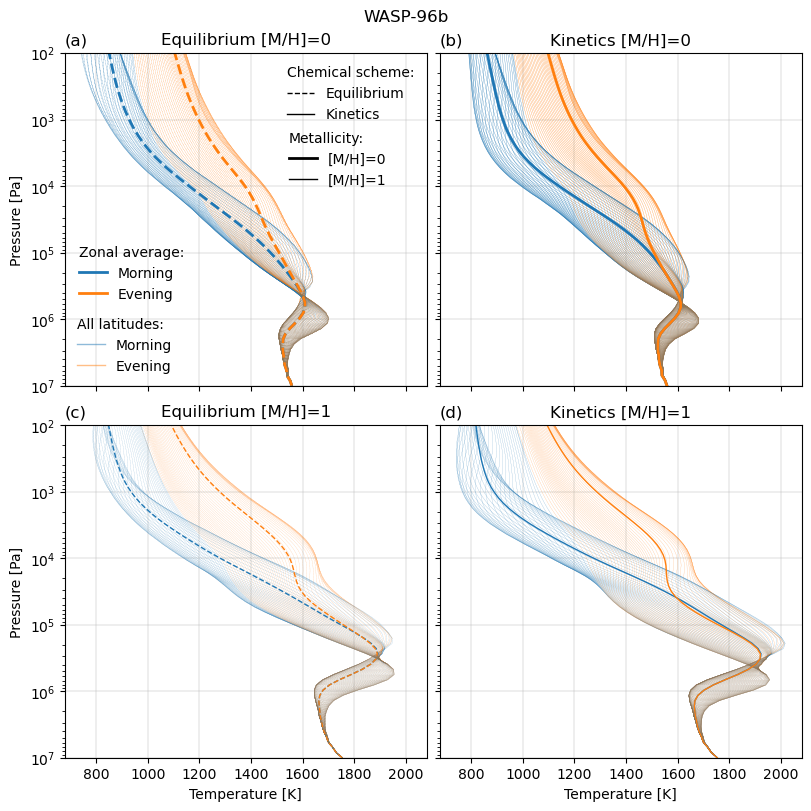

In [7]:
# Plot pressure-temperature profiles at limbs
fig, axs = plt.subplots(
    nrows=2, ncols=2, figsize=(8, 8), sharex=True, sharey=True, constrained_layout=True
)
for exp, exp_ls, axcol in zip(["equilibrium", "kinetics"], ["dashed", "solid"], axs.T):
    for mdh, mdh_lw, ax in zip(["mdh_0", "mdh_1"], [2, 1], axcol):
        ax.set_title(f"{exp.capitalize()} [M/H]={mdh[-1]}")
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel("Pressure [Pa]")
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel("Temperature [K]")
        for i, lat in enumerate(temp_plevs.coord("latitude").points):
            p_west_all = (
                vrbls[exp][mdh]["temp_plevs"]
                .extract(iris.Constraint(latitude=lat, longitude=91.25))
                .data
            )
            p_east_all = (
                vrbls[exp][mdh]["temp_plevs"]
                .extract(iris.Constraint(latitude=lat, longitude=271.25))
                .data
            )
            ax.plot(p_west_all, pres_coord, ls=exp_ls, lw=mdh_lw * 0.1, color="C0", alpha=0.5)
            ax.plot(p_east_all, pres_coord, ls=exp_ls, lw=mdh_lw * 0.1, color="C1", alpha=0.5)
        p_west_mean = vrbls[exp][mdh]["temp_plevs_limb_west_mean_wghtd"].data
        p_east_mean = vrbls[exp][mdh]["temp_plevs_limb_east_mean_wghtd"].data
        ax.plot(p_west_mean, pres_coord, ls=exp_ls, lw=mdh_lw, color="C0")
        ax.plot(p_east_mean, pres_coord, ls=exp_ls, lw=mdh_lw, color="C1")
for iax in axs.flatten():
    iax.set_yscale("log")
    iax.set_ylim(1e7, 1e2)
    iax.grid(lw=0.3)
axs[0, 0].set_title("(a)", loc="left")
axs[0, 1].set_title("(b)", loc="left")
axs[1, 0].set_title("(c)", loc="left")
axs[1, 1].set_title("(d)", loc="left")
# Legends
exp_dict = {
    "Equilibrium": {"color": "k", "ls": "dashed", "lw": 1},
    "Kinetics": {"color": "k", "ls": "solid", "lw": 1},
}
mdh_dict = {
    "[M/H]=0": {"color": "k", "ls": "solid", "lw": 2},
    "[M/H]=1": {"color": "k", "ls": "solid", "lw": 1},
}
limb_znl_ave_dict = {
    "Morning": {"color": "C0", "ls": "solid", "lw": 2},
    "Evening": {"color": "C1", "ls": "solid", "lw": 2},
}
limb_znl_all_dict = {
    "Morning": {"color": "C0", "ls": "solid", "lw": 1, "alpha": 0.5},
    "Evening": {"color": "C1", "ls": "solid", "lw": 1, "alpha": 0.5},
}
add_custom_legend(
    axs[0, 0],
    exp_dict,
    frameon=False,
    title="Chemical scheme:",
    alignment="left",
    loc="upper right",
)
add_custom_legend(
    axs[0, 0],
    mdh_dict,
    frameon=False,
    title="Metallicity:",
    alignment="left",
    bbox_to_anchor=(0.585, 0.56),
)
add_custom_legend(
    axs[0, 0],
    limb_znl_ave_dict,
    frameon=False,
    title="Zonal average:",
    alignment="left",
    bbox_to_anchor=(0.365, 0.46),
)
add_custom_legend(
    axs[0, 0],
    limb_znl_all_dict,
    frameon=False,
    title="All latitudes:",
    alignment="left",
    loc="lower left",
)
axs[0, 0].legend(frameon=False)
fig.suptitle(f'{PLANETS[planet]["tex"]}')
figname_png = f"{planet}_vp_pres_temp_limbs.png"
figname_pdf = f"{planet}_vp_pres_temp_limbs.pdf"
# fig.savefig(path_to_project / "circulation" / "vertical_profiles_pres_temp" / figname_png)
# fig.savefig(
#     path_to_project / "circulation" / "vertical_profiles_pres_temp" / figname_pdf,
#     format="pdf",
#     bbox_inches="tight",
# )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


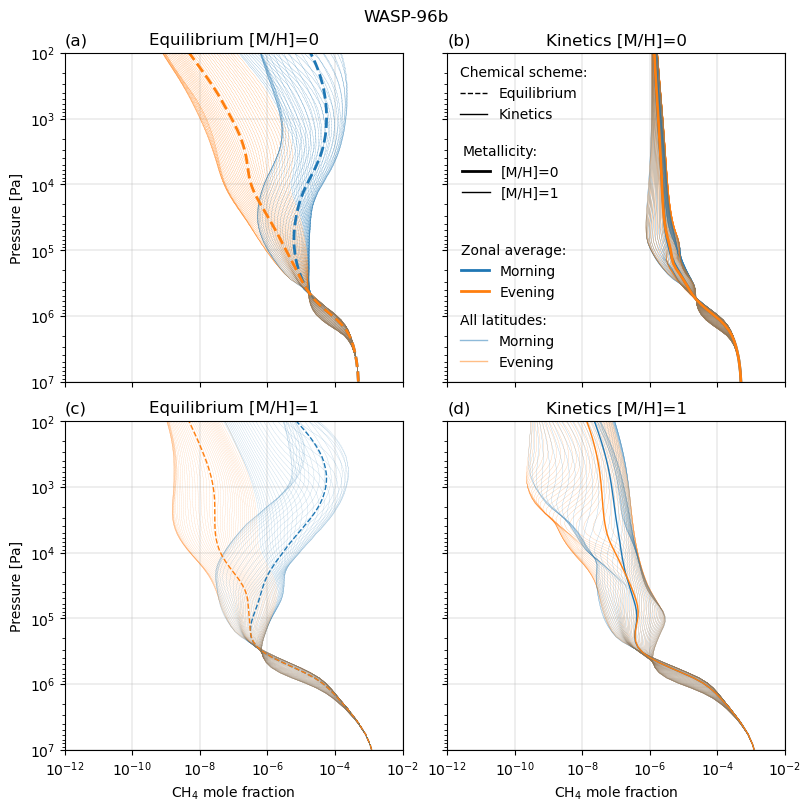

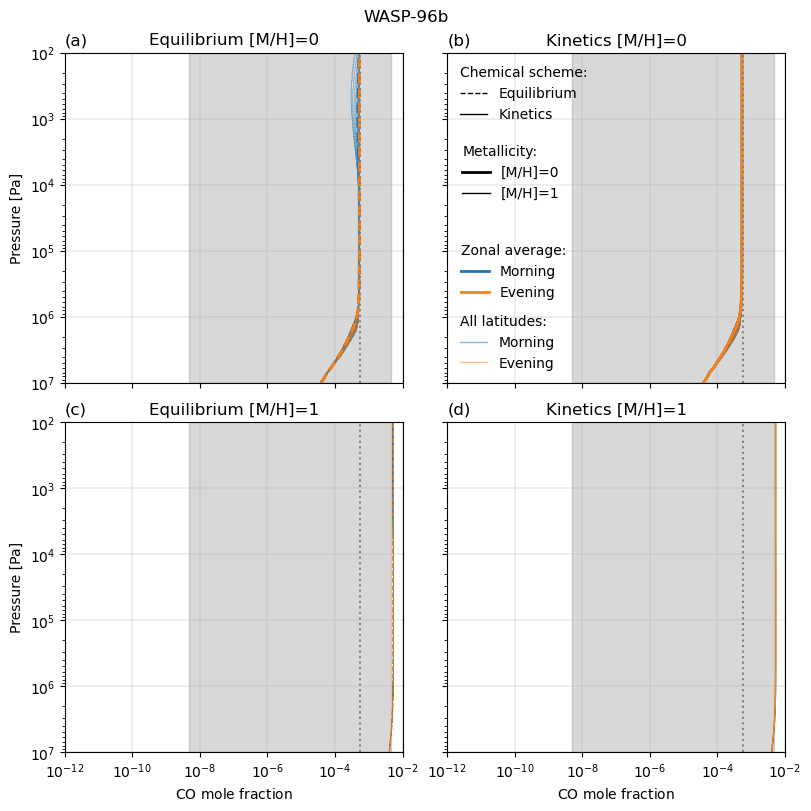

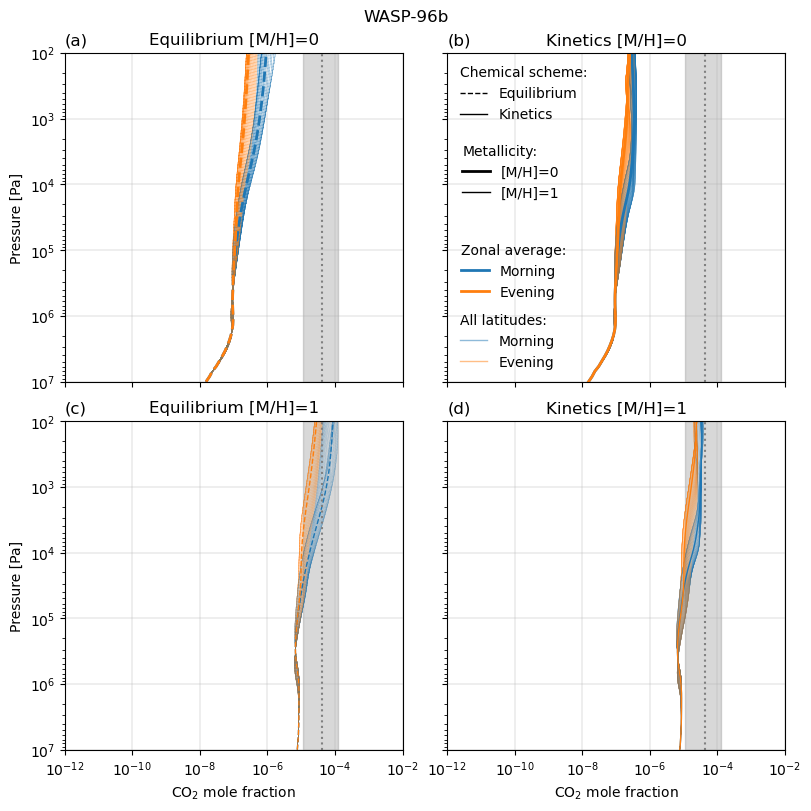

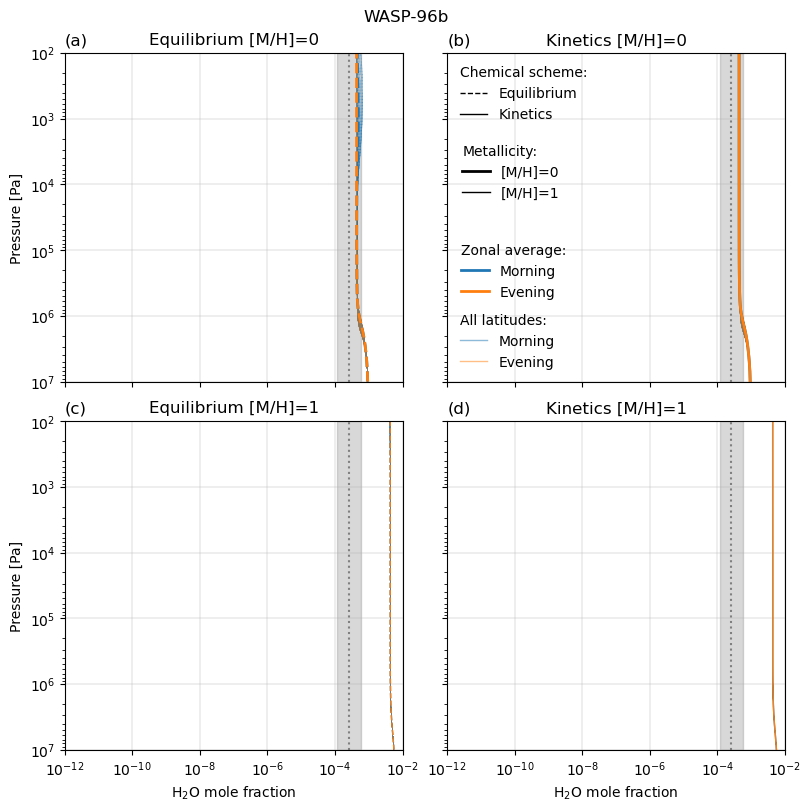

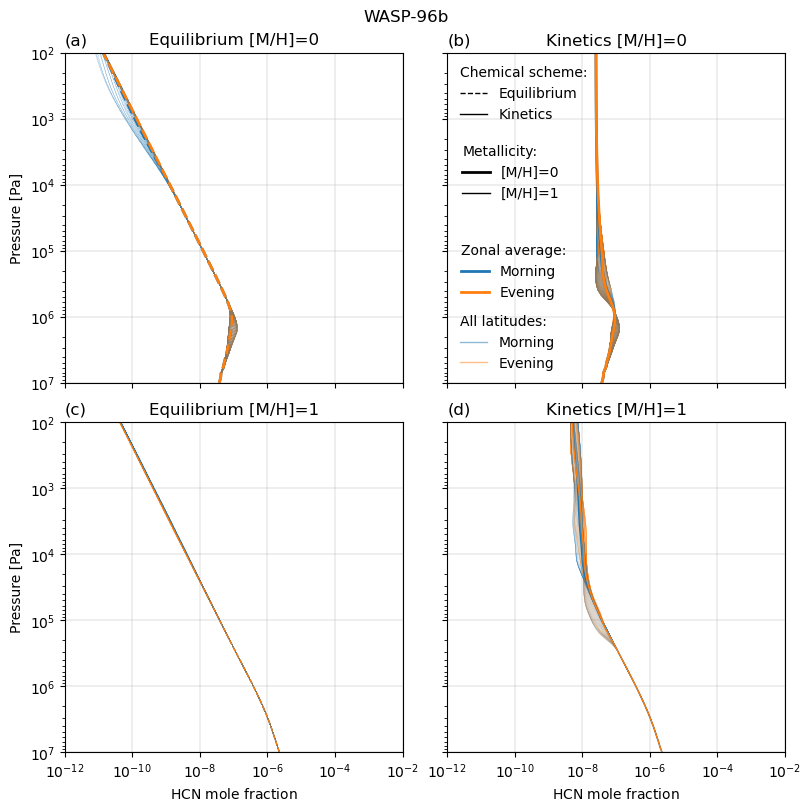

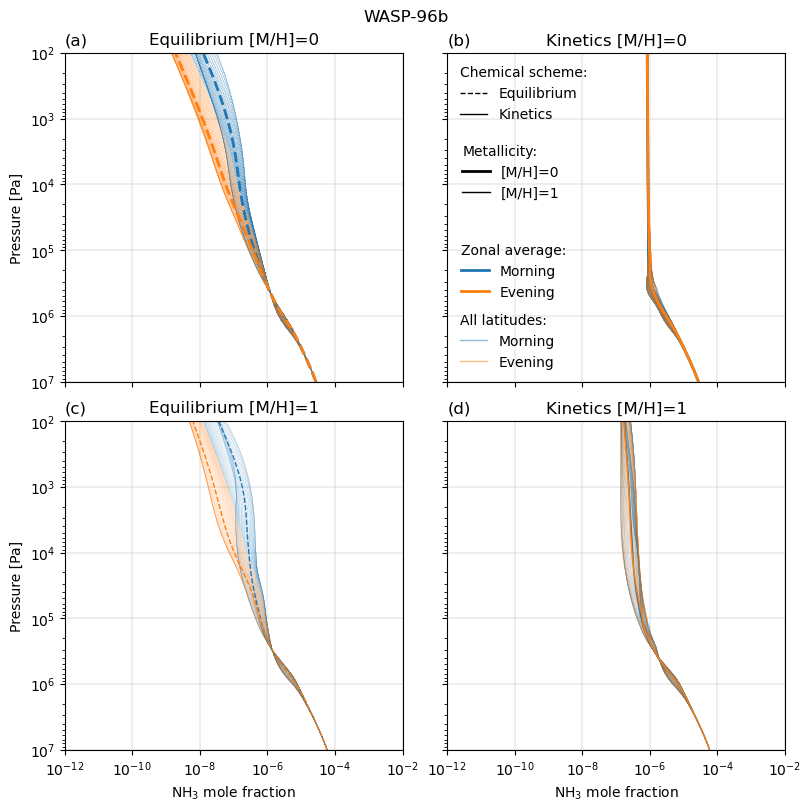

In [8]:
# Plot pressure-species profiles at limbs
for n, chem_name in enumerate(chem_names):
    fig, axs = plt.subplots(
        nrows=2, ncols=2, figsize=(8, 8), sharex=True, sharey=True, constrained_layout=True
    )
    for exp, exp_ls, axcol in zip(["equilibrium", "kinetics"], ["dashed", "solid"], axs.T):
        for mdh, mdh_lw, ax in zip(["mdh_0", "mdh_1"], [2, 1], axcol):
            ax.set_title(f"{exp.capitalize()} [M/H]={mdh[-1]}")
            if ax.get_subplotspec().is_first_col():
                ax.set_ylabel("Pressure [Pa]")
            if ax.get_subplotspec().is_last_row():
                ax.set_xlabel(f"{GASES[chem_name]['tex']} mole fraction")
            for i, lat in enumerate(temp_plevs.coord("latitude").points):
                p_west_all = (
                    vrbls[exp][mdh]["chem_plevs"]
                    .extract_cube(f"{chem_name} mole fraction")
                    .extract(iris.Constraint(latitude=lat, longitude=91.25))
                    .data
                )
                p_east_all = (
                    vrbls[exp][mdh]["chem_plevs"]
                    .extract_cube(f"{chem_name} mole fraction")
                    .extract(iris.Constraint(latitude=lat, longitude=271.25))
                    .data
                )
                ax.plot(p_west_all, pres_coord, ls=exp_ls, lw=mdh_lw * 0.1, color="C0", alpha=0.5)
                ax.plot(p_east_all, pres_coord, ls=exp_ls, lw=mdh_lw * 0.1, color="C1", alpha=0.5)
            p_west_mean = vrbls[exp][mdh]["chem_plevs_limb_west_mean_wghtd_cl"][n].data
            p_east_mean = vrbls[exp][mdh]["chem_plevs_limb_east_mean_wghtd_cl"][n].data
            ax.plot(p_west_mean, pres_coord, ls=exp_ls, lw=mdh_lw, color="C0")
            ax.plot(p_east_mean, pres_coord, ls=exp_ls, lw=mdh_lw, color="C1")
    for iax in axs.flatten():
        iax.set_xscale("log")
        iax.set_yscale("log")
        iax.set_xlim(1e-12, 1e-2)
        iax.set_ylim(1e7, 1e2)
        iax.grid(lw=0.3)
        if chem_name == "H2O":
            iax.axvline(x=pow(10, -3.59), color="grey", ls="dotted")
            iax.axvspan(pow(10, -3.59 - 0.35), pow(10, -3.59 + 0.35), alpha=0.3, color="grey")
        if chem_name == "CO":
            iax.axvline(x=pow(10, -3.25), color="grey", ls="dotted")
            iax.axvspan(pow(10, -3.25 - 5.06), pow(10, -3.25 + 0.91), alpha=0.3, color="grey")
        if chem_name == "CO2":
            iax.axvline(x=pow(10, -4.38), color="grey", ls="dotted")
            iax.axvspan(pow(10, -4.38 - 0.57), pow(10, -4.38 + 0.47), alpha=0.3, color="grey")
    axs[0, 0].set_title("(a)", loc="left")
    axs[0, 1].set_title("(b)", loc="left")
    axs[1, 0].set_title("(c)", loc="left")
    axs[1, 1].set_title("(d)", loc="left")
    # Legends
    exp_dict = {
        "Equilibrium": {"color": "k", "ls": "dashed", "lw": 1},
        "Kinetics": {"color": "k", "ls": "solid", "lw": 1},
    }
    mdh_dict = {
        "[M/H]=0": {"color": "k", "ls": "solid", "lw": 2},
        "[M/H]=1": {"color": "k", "ls": "solid", "lw": 1},
    }
    limb_znl_ave_dict = {
        "Morning": {"color": "C0", "ls": "solid", "lw": 2},
        "Evening": {"color": "C1", "ls": "solid", "lw": 2},
    }
    limb_znl_all_dict = {
        "Morning": {"color": "C0", "ls": "solid", "lw": 1, "alpha": 0.5},
        "Evening": {"color": "C1", "ls": "solid", "lw": 1, "alpha": 0.5},
    }
    add_custom_legend(
        axs[0, 1],
        exp_dict,
        frameon=False,
        title="Chemical scheme:",
        alignment="left",
        loc="upper left",
    )
    add_custom_legend(
        axs[0, 1],
        mdh_dict,
        frameon=False,
        title="Metallicity:",
        alignment="left",
        bbox_to_anchor=(0.37, 0.76),
    )
    add_custom_legend(
        axs[0, 1],
        limb_znl_ave_dict,
        frameon=False,
        title="Zonal average:",
        alignment="left",
        bbox_to_anchor=(0.39, 0.46),
    )
    add_custom_legend(
        axs[0, 1],
        limb_znl_all_dict,
        frameon=False,
        title="All latitudes:",
        alignment="left",
        loc="lower left",
    )
    axs[0, 1].legend(frameon=False)
    fig.suptitle(f'{PLANETS[planet]["tex"]}')
    figname_png = f"{planet}_vp_pres_{chem_name.lower()}_limbs.png"
    figname_pdf = f"{planet}_vp_pres_{chem_name.lower()}_limbs.pdf"
    # fig.savefig(path_to_project / "chemistry" / "vertical_profiles_pres_chem" / figname_png)
    # fig.savefig(
    #     path_to_project / "chemistry" / "vertical_profiles_pres_chem" / figname_pdf,
    #     format="pdf",
    #     bbox_inches="tight",
    # )